In [1]:
### We start with geometric brownian motion.
# We need to simulate n brownian motion paths, then 
# Construct their average after some time and verify it's correct. I want to write code that does this
# for just 3 cases, that's very easy. That I can do tomorrow


# Then I want to do the sam ebut via a finite difference scheme. That's a little trickier, but 
# I can still understand it. 
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

First, implement an MC version that solves for the price of a European option.
Recall: We assume that the Stock evolves with Geometric Brownian Motion, but at the risk free rate

$ \frac{dS}{S_t} = r dt + \sigma dW_t$ \
$ S_t = S_0 e^{(r - \frac{\sigma^2}{2})t + \sigma W_t} $







In [ ]:
# Goal 1: Write code that calculates the cost of a European Call option and compare it

def eu_call_price(S0, K, T, r, sigma):
    d_plus = 1/(sigma * np.sqrt(T)) * (np.log(S0/K) + (r + 0.5*sigma**2)*T)
    d_minus = d_plus - sigma * np.sqrt(T)
    C = norm.cdf(d_plus) * S0 - norm.cdf(d_minus) * K * np.exp(-r * T)
    return C

def eu_put_price(S0, K, T, r, sigma):
    C = eu_call_price(S0, K, T, r, sigma)
    P = K * np.exp(-r*T) - S0 + C
    return P

def geometric_asian_call_price(S0, K, T, r, sigma):
    
    sigma_g = sigma /np.sqrt(3)
    b = 1/2 * (r - 1/2 * sigma_g**2)
    d1 = (np.log(S0/K) + (b + 1/2 * sigma_g**2)*T)/(sigma_g * np.sqrt(T))
    d2 = d1 - sigma_g * np.sqrt(T)
    call = S0 * np.exp(b - r)*T * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put = call - S0 * np.exp((b - r) * T) + K * np.exp(-r * T)

    return call, put

def MC_call(S0, K, T, r, sigma, N=1000, M=1000, option_type='european'):
    """
    N: Number of timesteps
    M: Number of trials
    """
    dt = T / N
    discount_factor = np.exp(-r*T)
    S_paths = np.zeros((M, N+1))
    S_paths[:, 0] = S0
    for i in range(1, N+1):
        Z = np.random.randn(M)
        S_paths[:, i] = S_paths[:, i - 1] * np.exp((r - sigma**2/2) * dt + sigma * np.sqrt(dt) * Z)
    if option_type == 'european':
        S_terminal = S_paths[:, -1]
    elif option_type == 'arithmetic asian':
        S_terminal = np.mean(S_paths, axis=1)
    elif option_type == 'geometric asian':
        S_terminal = np.exp(np.mean(np.log(S_paths + 1e-8), axis=1))
    
    payoffs = np.maximum(S_terminal - K, 0)
    option_price = discount_factor * np.mean(payoffs)

    return option_price

S0 = 90; K = 100; T = 1; r = 0.04; sigma=0.15
analytic_european_call = eu_call_price(S0, K, T, r, sigma)
analytic__geometric_call, _ = geometric_asian_call_price(S0, K, T, r, sigma)
mc_european_call = MC_call(S0, K, T, r, sigma, 1000, 100000, option_type='european')
mc_geometric_call = MC_call(S0, K, T, r, sigma, 10000, 100000, option_type='geometric asian')
print('European calls: ', analytic_european_call, mc_european_call)
print('Geometric Asian Call', analytic__geometric_call, mc_geometric_call)


European calls:  3.0415722887553294 3.0232917105865846
Geometric Asian Call 0.6540779351186838 0.6631594403999893


In [22]:
## Investigating convergence
M_vals = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
S0 = 90; K = 100; T = 1; r = 0.04; sigma=0.15
european_call_prices = {}
num_averages = 20
for M in M_vals:
    print(M)
    european_call_prices[M] = []
    for _ in range(num_averages):
        call_price = MC_call(S0, K, T, r, sigma, 1000, M, option_type='european')
        european_call_prices[M].append(call_price)

10
100
1000
10000
100000
1000000


In [23]:
np.mean(european_call_prices[10**2])
print(european_call_prices[10**2])

[np.float64(2.6302588662350397), np.float64(3.5807669636137156), np.float64(2.610736174073131), np.float64(3.352570717239613), np.float64(4.636818565815142), np.float64(3.218159581585855), np.float64(2.4956412580981), np.float64(2.3686774966387456), np.float64(2.8853169532966287), np.float64(2.3415631764172864), np.float64(3.5701289388243365), np.float64(2.4586773708814498), np.float64(3.7094509832940474), np.float64(3.288909584254232), np.float64(4.393941873440635), np.float64(3.157755932151198), np.float64(3.0050762949995207), np.float64(2.918927954298117), np.float64(1.9602300418384233), np.float64(2.5884755857525414)]


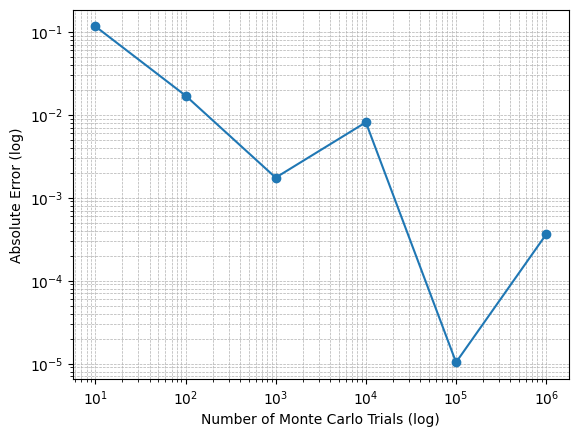

In [24]:
true_price = eu_call_price(S0, K, T, r, sigma)
error = [abs(true_price - np.mean(prices)) for prices in european_call_prices.values()]
plt.loglog(european_call_prices.keys(), error, marker='o', linestyle='-')
plt.axhline(y=0, color='black', linestyle='dashed', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Monte Carlo Trials (log)')
plt.ylabel('Absolute Error (log)')
plt.grid(which='both', linestyle='--', linewidth=0.5)

Beautiful, I will now implement Antithetic variates to see if they can reduce the variance we observe in these variables


In [ ]:
def MC_call(S0, K, T, r, sigma, N=1000, M=1000, option_type='european', antithetic=True):
    """
    N: Number of timesteps
    M: Number of trials
    """
    dt = T / N
    discount_factor = np.exp(-r*T)

    if antithetic:
        M = M // 2

    S_paths = np.zeros((2 * M if antithetic else M, N+1))
    S_paths[:, 0] = S0

    for i in range(1, N+1):
        Z = np.random.randn(M)

        if antithetic:
            Z_antithetic = -Z
            Z_combined = np.concatenate((Z, Z_antithetic))
        else:
            Z_combined = Z
        S_paths[:, i] = S_paths[:, i - 1] * np.exp((r - sigma**2/2) * dt + sigma * np.sqrt(dt) * Z_combined)
    if option_type == 'european':
        S_terminal = S_paths[:, -1]
    elif option_type == 'arithmetic asian':
        S_terminal = np.mean(S_paths, axis=1)
    elif option_type == 'geometric asian':
        S_terminal = np.exp(np.mean(np.log(S_paths + 1e-8), axis=1))
    
    payoffs = np.maximum(S_terminal - K, 0)
    option_price = discount_factor * np.mean(payoffs)

    return option_price

M_vals = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
S0 = 90; K = 100; T = 1; r = 0.04; sigma=0.15
european_call_prices_antithetic = {}
european_call_prices = {}
num_averages = 50
for M in M_vals:
    print(M)
    european_call_prices_antithetic[M] = []
    european_call_prices[M] = []
    for _ in range(num_averages):
        call_price = MC_call(S0, K, T, r, sigma, 1000, M, option_type='european', antithetic=True)
        european_call_prices_antithetic[M].append(call_price)
        call_price = MC_call(S0, K, T, r, sigma, 1000, M, option_type='european', antithetic=False)
        european_call_prices[M].append(call_price)

true_price = eu_call_price(S0, K, T, r, sigma)
error_antithetic = [abs(true_price - np.mean(prices)) for prices in european_call_prices_antithetic.values()]
error = [abs(true_price - np.mean(prices)) for prices in european_call_prices.values()]



10
100
1000
10000
100000
1000000


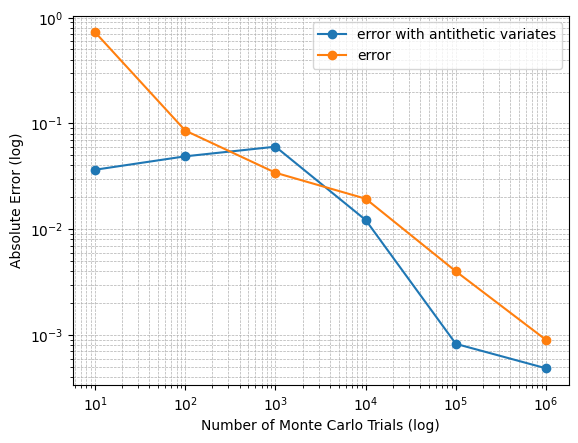

In [29]:
plt.loglog(european_call_prices_antithetic.keys(), error_antithetic, marker='o', linestyle='-', label='error with antithetic variates')
plt.loglog(european_call_prices.keys(), error, marker='o', linestyle='-', label='error')
plt.axhline(y=0, color='black', linestyle='dashed', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Monte Carlo Trials (log)')
plt.ylabel('Absolute Error (log)')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)

Ok amazing. The antithetic variates reduces the error in the MC prices.

Next I want to compare using control variates, and then combining that with antithetic variates



In [48]:
import numpy as np
import scipy.stats as stats

def geometric_brownian_motion(s, sigma, r, T, N, n, antithetic=True):
    """Simulate paths using vectorized Geometric Brownian Motion with Antithetic Variates."""
    h = T / N
    half_n = n // 2 if antithetic else n
    W = np.random.randn(half_n, N)  # Generate standard normal samples

    # Compute stock price paths
    path = s * np.exp((r - sigma ** 2 / 2) * h * np.cumsum(np.ones((half_n, N)), axis=1) +
                      sigma * np.sqrt(h) * np.cumsum(W, axis=1))

    if antithetic:
        # Compute antithetic paths using -W
        path_antithetic = s * np.exp((r - sigma ** 2 / 2) * h * np.cumsum(np.ones((half_n, N)), axis=1) +
                                     sigma * np.sqrt(h) * np.cumsum(-W, axis=1))
        path = np.vstack((path, path_antithetic))  # Combine both sets of paths

    path = np.concatenate((s * np.ones((path.shape[0], 1)), path), axis=1)  # Include S0
    return path

class CVMCAsianCallOption:
    """Compute the price of an Arithmetic Asian Call using Control Variates and Antithetic Variates."""
    
    def __init__(self, initial_price, volatility, interest_rate, time_to_maturity, strike_price, N, n, antithetic=True):
        self.initial_price = initial_price
        self.volatility = volatility
        self.interest_rate = interest_rate
        self.time_to_maturity = time_to_maturity
        self.strike_price = strike_price
        self.N = N
        self.n = n
        self.antithetic = antithetic

    def compute(self):
        """Compute Asian Call price using Control Variates and Antithetic Variates."""
        # Compute Geometric Asian Call price analytically
        q = 0.5 * (self.interest_rate - (self.volatility**2 / 6))
        d1 = (np.log(self.initial_price / self.strike_price) + (q * self.time_to_maturity)) / \
             (self.volatility * np.sqrt(self.time_to_maturity / 3))
        d2 = d1 - self.volatility * np.sqrt(self.time_to_maturity / 3)

        geometric_call_price = np.exp(-self.interest_rate * self.time_to_maturity) * \
                               (np.exp(q * self.time_to_maturity) * self.initial_price * stats.norm.cdf(d1) - 
                                self.strike_price * stats.norm.cdf(d2))

        # Simulate stock paths using GBM with Antithetic Variates
        stockpath = geometric_brownian_motion(self.initial_price, self.volatility, self.interest_rate,
                                              self.time_to_maturity, self.N, self.n, self.antithetic)

        # Compute payoffs
        arithmetic_payoff = np.maximum(np.mean(stockpath, axis=1) - self.strike_price, 0)
        geometric_payoff = np.maximum(stats.mstats.gmean(stockpath, axis=1) - self.strike_price, 0)

        # Compute optimal control variate coefficient c*
        c_optimal = np.cov(arithmetic_payoff, geometric_payoff)[0, 1] / np.var(geometric_payoff)

        # Apply control variate adjustment
        adjusted_payoff = arithmetic_payoff - c_optimal * (geometric_payoff - geometric_call_price)

        # Compute Monte Carlo estimate
        price = np.exp(-self.interest_rate * self.time_to_maturity) * np.mean(adjusted_payoff)

        # Compute 95% confidence interval
        conf95 = 1.96 * np.std(adjusted_payoff) / np.sqrt(self.n)

        return price, conf95

# Example usage
option_antithetic = CVMCAsianCallOption(90, 0.15, 0.04, 1, 100, 1000, 5000, antithetic=True)
option_nonantithetic = CVMCAsianCallOption(90, 0.15, 0.04, 1, 100, 1000, 5000, antithetic=False)
price_antithetic, conf95_antithetic = option_antithetic.compute()
price_nonantithetic, conf95_nonantithetic = option_nonantithetic.compute()

print(f"Arithmetic Asian Call Option Price (CV + Antithetic): {price_antithetic:.4f}")
print(f"Arithmetic Asian Call Option Price (CV): {price_nonantithetic:.4f}")
print(f"95% Confidence Interval: ±{conf95_antithetic:.4f}")
print(f"95% Confidence Interval: ±{conf95_nonantithetic:.4f}")


Arithmetic Asian Call Option Price (CV + Antithetic): 0.6795
Arithmetic Asian Call Option Price (CV): 0.6801
95% Confidence Interval: ±0.0027
95% Confidence Interval: ±0.0028


Now we consider finite difference schemes for pricing Asian options
Firstly an explicit one

In [59]:
import numpy as np

def explicit_fd_asian_option(S0, K, T, r, sigma, Smax, Amax, M, P, N):
    """
    Explicit Finite Difference method for pricing an Arithmetic Asian Call Option.
    
    This implementation uses a two-dimensional grid in:
      - S: the asset price (0 to Smax) with M+1 nodes,
      - A: the running average (0 to Amax) with P+1 nodes,
    and time t from 0 to T (N+1 nodes).
    
    The PDE (in a simplified form) is:
      ∂V/∂t + 0.5 σ² S² ∂²V/∂S² + r S ∂V/∂S + (S - A)/t * ∂V/∂A - rV = 0,
    with terminal condition V(S,A,T) = max(A - K, 0).
    
    Parameters:
      S0    : initial asset price
      K     : strike price
      T     : time to maturity
      r     : risk-free interest rate
      sigma : volatility
      Smax  : maximum asset price on grid
      Amax  : maximum average on grid
      M     : number of steps in S
      P     : number of steps in A
      N     : number of time steps
      
    Returns:
      V           : 3D array of option values, with indices (S, A, t)
      S           : asset price grid (1D array)
      A           : average grid (1D array)
      t           : time grid (1D array)
      option_price: interpolated option price at (S0, A_mid, t=0)
    """
    
    dS = Smax / M
    dA = Amax / P
    dt = T / N
    
    # Grids for S, A, and t
    S = np.linspace(0, Smax, M+1)
    A = np.linspace(0, Amax, P+1)
    t = np.linspace(0, T, N+1)
    
    # V[i,j,n] will approximate V(S[i], A[j], t[n])
    V = np.zeros((M+1, P+1, N+1))
    
    # Terminal condition at t = T: payoff = max(A - K, 0)
    for j in range(P+1):
        V[:, j, -1] = np.maximum(A[j] - K, 0)
    
    # Boundary conditions in S: if S = 0, option value = 0.
    V[0, :, :] = 0
    # Boundary conditions in A:
    #   At A = 0, assume option is worthless.
    V[:, 0, :] = 0
    #   At A = Amax, use an intrinsic approximation.
    V[:, -1, :] = Amax - K
    
    # Backward time-stepping: loop from n = N-1 down to 0.
    for n in range(N-1, -1, -1):
        # Use a safeguard for t to avoid division by zero
        t_star = max(t[n+1], dt)
        for i in range(1, M):
            for j in range(1, P):
                # Finite difference coefficients in S
                # Using central differences for ∂²V/∂S² and ∂V/∂S
                alpha = 0.5 * dt * (sigma**2 * S[i]**2 / dS**2 - r * S[i] / dS)
                beta  = 1 - dt * (sigma**2 * S[i]**2 / dS**2 + r)
                gamma = 0.5 * dt * (sigma**2 * S[i]**2 / dS**2 + r * S[i] / dS)
                
                # Finite difference for the derivative in A using backward difference:
                # ∂V/∂A ≈ (V[i, j, n+1] - V[i, j-1, n+1]) / dA.
                delta = dt * (S[i] - A[j]) / (t_star * dA)
                
                V[i, j, n] = (alpha * V[i-1, j, n+1] +
                              beta  * V[i,   j, n+1] +
                              gamma * V[i+1, j, n+1] +
                              delta * (V[i, j, n+1] - V[i, j-1, n+1]))
    
    # For the purpose of interpolation, choose an average level.
    # A natural choice is to use A ~ S0 (if S0 <= Amax); otherwise use A_max.
    A_target = S0 if S0 <= Amax else A[-1]
    # For simplicity, here we use the midpoint in the A grid as a proxy.
    option_price = np.interp(S0, S, V[:, int(P/2), 0])
    
    return V, S, A, t, option_price

# ----------------------------
# Example Usage

# Parameter set
S0 = 90         # Initial stock price
K = 100         # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.04        # Risk-free rate
sigma = 0.15    # Volatility
Smax = 300      # Maximum stock price in grid
Amax = 300      # Maximum average in grid
M = 200         # Number of S steps
P = 200         # Number of A steps
N = 10000        # Number of time steps

V, S, A, t, option_price = explicit_fd_asian_option(S0, K, T, r, sigma, Smax, Amax, M, P, N)
print(f"Arithmetic Asian Call Option Price (Explicit FD): {option_price:.4f}")


/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_17785/2557670623.py:76: RuntimeWarning: overflow encountered in scalar add
  V[i, j, n] = (alpha * V[i-1, j, n+1] +
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_17785/2557670623.py:79: RuntimeWarning: overflow encountered in scalar multiply
  delta * (V[i, j, n+1] - V[i, j-1, n+1]))
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_17785/2557670623.py:79: RuntimeWarning: overflow encountered in scalar subtract
  delta * (V[i, j, n+1] - V[i, j-1, n+1]))


Arithmetic Asian Call Option Price (Explicit FD): -57482943054294171598313853219535240328629430195605608545919226659021212527444292050651971584.0000


In [74]:
class AsianCallOption(object):
    def __init__(self, initial_price,
                 strike_price,
                 interest_rate,
                 volatility,
                 time_to_maturity: int,
                 time_partition_size: int,
                 spatial_partition_size: int):
        super(AsianCallOption, self).__init__()
        self.initial_price = initial_price
        self.strike_price = strike_price
        self.interest_rate = interest_rate
        self.volatility = volatility
        self.time_to_maturity = time_to_maturity
        self.time_partition_size = time_partition_size
        self.spatial_partition_size = spatial_partition_size

    def solve(self, spatial_size=3):
        self.spatial_size = spatial_size

        dt = self.time_to_maturity / self.time_partition_size
        dz = 2 * (self.spatial_size / self.spatial_partition_size)
        d = dt / dz ** 2

        u = np.zeros((self.time_partition_size+1, self.spatial_partition_size+1))
        #time = np.mslice[0:dt:self.time_to_maturity]
        spatial = np.array([-self.spatial_size+i*dz for i in range(self.spatial_partition_size+1)])
        time = np.array([0+i*dt for i in range(self.time_partition_size+1)])


        # Initial conditions and boundary conditions
        for j in range(self.spatial_partition_size+1):
            u[0, j] = np.max([spatial[j], 0])
        u[1:, 0] = 0
        u[1:, -1] = np.max([spatial[j], 0])

        for i in range(1, self.time_partition_size+1):
            # Gamma functions
            gamma_forward = (1 - np.exp(-self.interest_rate * time[i-1])) / (self.interest_rate * self.time_to_maturity)
            gamma_backward = (1 - np.exp(-self.interest_rate * time[i])) / (self.interest_rate * self.time_to_maturity)

            # Argument for matrices
            arg_A_forw = 0.5 * d * (self.volatility**2 / 2) * (gamma_forward - spatial[1:-1])**2
            arg_A_backw = -0.5 * d * (self.volatility**2 / 2) * (gamma_forward - spatial[1:-1])**2


            # Creating matrices and diagonals
            A_forw = np.zeros((self.spatial_partition_size-1, self.spatial_partition_size-1)) + np.diag(1-2*arg_A_forw)
            A_backw = np.zeros((self.spatial_partition_size-1, self.spatial_partition_size-1)) + np.diag(1-2*arg_A_backw)

            # Non-diagonals
            for j in range(self.spatial_partition_size-2):
                A_forw[j+1, j] = arg_A_forw[j+1]
                A_forw[j, j+1] = arg_A_forw[j]

                A_backw[j+1, j] = arg_A_backw[j+1]
                A_backw[j, j+1] = arg_A_backw[j]

            # Boundary vector (arguments but with the last spatial partition element)
            b_forw = np.zeros((self.spatial_partition_size-1))
            b_backw = np.zeros((self.spatial_partition_size-1))
            b_forw[-1] = self.spatial_size * 0.5 * d * (self.volatility**2 / 2) * (gamma_forward - spatial[-1])**2
            b_backw[-1] = -self.spatial_size * 0.5 * d * (self.volatility**2 / 2) * (gamma_backward - spatial[-1])**2

            # Solving
            matrices = np.matmul(u[i-1, 1:-1], np.matmul(np.transpose(np.linalg.inv(A_backw)), np.transpose(A_forw)))
            b_vectors = np.matmul(b_forw.T, np.transpose(np.linalg.inv(A_backw))) - np.matmul(b_backw.T, np.transpose(np.linalg.inv(A_backw)))

            u[i, 1:-1] = matrices + b_vectors

        # Compute spatial value from theorem (Q(0) = 0)
        z_left = 1 / (self.interest_rate * self.time_to_maturity) * (1 - np.exp(-self.interest_rate * self.time_to_maturity))
        z_right = -self.strike_price * np.exp(-self.interest_rate * self.time_to_maturity) / self.initial_price
        z = z_left + z_right

        # Interpolate to find closest possible
        correct_z = 0
        for k in range(self.spatial_partition_size):
            if z >= spatial[k] and z <= spatial[k+1]:
                correct_z = int(np.round((k + (k + 1)) / 2))

        price = self.initial_price * u[-1, correct_z]
        return price
    
asian_fd_call = AsianCallOption(initial_price=90, strike_price=100, interest_rate=0.04, volatility=0.15, 
                                time_to_maturity=1, time_partition_size=1000, spatial_partition_size=100)
asian_fd_call_price = asian_fd_call.solve(spatial_size=3)
print(asian_fd_call_price)

0.3398887402048574


In [ ]:
import numpy
import math

class Option:
    def __init__(self, maxt, numx, numt, r, sigma, s0, avr, t0):
        self.maxt = maxt
        self.numx = numx
        self.numt = numt
        self.r = r
        self.sigma = sigma
        self.s0 = s0
        self.old_average = avr
        self.t0 = t0
        self.dt = maxt / float(numt)
        self.xi_min = 0
        self.xi_initial = self.xi(self.s0, 0)
        self.maxx = 2
        # One extra time point to account for t = 0
        self.grid = numpy.matrix([[0] * (self.numt + 1)] * (self.numx + 1), dtype = numpy.float64)

    def q(self, t):
        return (1 - math.exp(-self.r*(self.maxt - t))) / (self.r * (self.t0 + self.maxt))

    def avr(self, t):
        return self.q(t) * self.s0 + math.exp(-self.r * (self.maxt - t)) * self.t0 * self.old_average / (self.t0 + self.maxt)

    def set_boundary_conditions(self):
        self.set_bottom_boundary()
        self.set_top_boundary()
        self.set_initial_boundary()

    def solve(self, left_multiplier, right_multiplier):
        for col in range(self.numt):
            l = self.grid[:, col]
            r = self.grid[:, col + 1]
            new = numpy.linalg.solve(left_multiplier(col), right_multiplier(col) * l)
            for row in range(self.numx + 1):
                self.grid.itemset((row, col + 1), new[row])
        return self.interpolate()

    def interpolate(self):
        y0 = self.s0 * self.grid[self.j0, self.numt]
        y1 = self.s0 * self.grid[self.j0 + 1, self.numt]
        x = self.xi_initial
        x0 = self.j0 * self.dx + self.xi_min
        x1 = (self.j0 + 1) * self.dx + self.xi_min
        return y0 + (x - x0) * (y1 - y0) / (x1 - x0)

    def set_bottom_boundary(self):
        for i in range(self.numt + 1):
            self.grid.itemset((0, i), self.initial_value_at_bottom(i))

    def set_top_boundary(self):
        for i in range(self.numt + 1):
            self.grid.itemset((self.numx, i), self.initial_value_at_top(i))

    def set_initial_boundary(self):
        for j in range(self.numx + 1):
            self.grid.itemset((j, 0), self.initial_value_at_height(j))

    def A_matrix(self, time, lower, curr, upper):
        A = numpy.matrix([[0] * (self.numx + 1)] * (self.numx + 1), dtype = numpy.float64)
        for i in range(self.numx + 1):
            a = self.alpha(i, time)
            b = self.beta(i, time)
            if i - 1 >= 0:
                A.itemset((i, i - 1), lower(a, b))
            A.itemset((i, i), curr(a, b))
            if i + 1 <= self.numx:
                A.itemset((i, i + 1), upper(a, b))
        return A

    def B_matrix(self, time, lower, curr, upper):
        A = numpy.matrix([[0] * (self.numx + 1)] * (self.numx + 1), dtype = numpy.float64)
        for i in range(self.numx + 1):
            a = self.alpha(i, time)
            b = self.beta(i, time)
            if i - 1 >= 0:
                A.itemset((i, i - 1), lower(a, b))
            A.itemset((i, i), curr(a, b))
            if i + 1 <= self.numx:
                A.itemset((i, i + 1), upper(a, b))
        return A

    # Stub methods
    def alpha(self, height, time):
        return 0

    def beta(self, height, time):
        return 0

    def a(self, t):
        return 0

    def b(self, t):
        return 0

    def initial_value_at_height(self, j):
        return 0

    def initial_value_at_top(self, i):
        return 0

    def initial_value_at_bottom(self, i):
        return 0

    def xi(self, s, t):
        return 0
    

/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_17785/1410019829.py:59: RuntimeWarning: overflow encountered in scalar divide
  u_yy = (u[j+1, n+1] - 2*u[j, n+1] + u[j-1, n+1]) / (dy**2)
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_17785/1410019829.py:65: RuntimeWarning: invalid value encountered in scalar add
  u[j, n] = u[j, n+1] - dt * ( 0.5 * sigma**2 * y_grid[j]**2 * u_yy + coef * u_y )


Asian Call Option Price (Vecer FD): nan


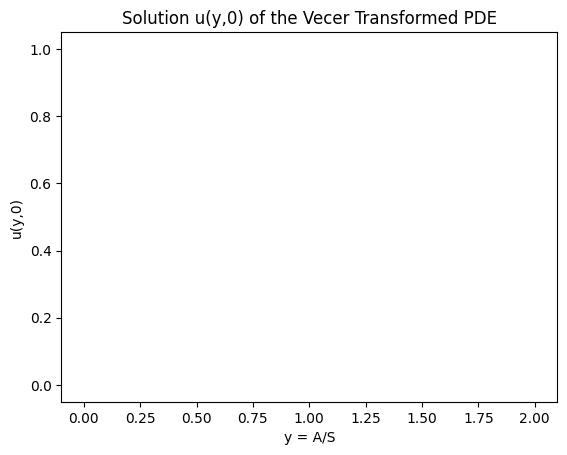

In [2]:
import sys
sys.path.append(".")
from asian_new_vecer_fixed_call import AsianNewVecerFixedCall
from asian_vecer_fixed_call import AsianVecerFixedCall

asian_call_fd = AsianVecerFixedCall(maxt=1, numx=200, numt=100000, r=0.04, sigma=0.15,
                                    initial_price=90, strike=100)
asian_call_fd_new = AsianNewVecerFixedCall(maxt=1, numx=200, numt=10000, r=0.04, sigma=0.15, 
                                    initial_price=90, strike=100)
asian_call_fd_new_price = asian_call_fd_new.solve()
asian_call_fd_price = asian_call_fd.solve()
print(asian_call_fd_price, asian_call_fd_new_price)

0.7093258089791502 0.7210831682160124
